### Imports

In [1]:
import base64
import os
from copy import deepcopy
from io import BytesIO
from typing import List

from PIL import Image
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

from client import DetectionClient, SegmentationClient
from client.utils import draw_detections

BASE_URL="https://w1dt08xwmcl4vw-8008.proxy.runpod.net/"
VLLM_BASE_URL=os.path.join(BASE_URL, "vllm/v1")
IMAGE_BASE_URL=os.path.join(BASE_URL, "image")

TEST_IMAGE=Image.open("./test.jpg")

### Multimodal VLLM Inference

#### Normal Usage

In [2]:
buffered = BytesIO()
TEST_IMAGE.save(buffered, format="JPEG")
img_base64 = base64.b64encode(buffered.getvalue()).decode()

chat = ChatOpenAI(
    model="model",
    api_key="EMPTY",
    base_url=VLLM_BASE_URL,
    max_tokens=8192,
    extra_body={
        "chat_template_kwargs": {"enable_thinking": False}
    },
)

chat_thinking = ChatOpenAI(
    model="model",
    api_key="EMPTY",
    base_url=VLLM_BASE_URL,
    max_tokens=8192,
    extra_body={
        "chat_template_kwargs": {"enable_thinking": True}
    },
)

messages = [
    SystemMessage(content="You are a helpful assistant that can see and understand images."),
    HumanMessage(content=[
        {"type": "text", "text": "What is in this image? Explain in great detail."},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}}
    ]),
]

In [3]:
chunks_thinking = []
for chunk in chat_thinking.stream(messages):
    print(chunk.content, end="", flush=True)
    chunks_thinking.append(chunk)

So, let's break down what's in this image. First, the main subject is a city skyline, which I recognize as Chicago's. Let's start with the foreground: there's a large body of water, probably Lake Michigan, reflecting the city buildings. The water is calm, so the reflections are very clear, mirroring the skyscrapers almost perfectly. That's a key detail— the stillness of the water creates a symmetrical effect with the cityscape above.

Now, the skyline itself. There are numerous high-rise buildings, each with distinct architectural styles. Let's identify some notable ones. On the left, there's the Willis Tower (formerly Sears Tower), which is the tallest building here, with its distinctive black and white design and antenna. Then, moving right, there's the Trump International Hotel and Tower, which is that tall, sleek building with a reflective glass facade. The John Hancock Center is another recognizable one, with its unique X-bracing. The Aon Center (formerly Standard Oil Building) is

In [4]:
chunks = []
for chunk in chat.stream(messages):
    print(chunk.content, end="", flush=True)
    chunks.append(chunk)

So, let's break down this image. First, it's a cityscape, probably Chicago, given the skyline and the lake. The main elements are the skyscrapers, the water, and the sky. Let's start with the buildings.

In the foreground, there's a large body of water, which is calm, so it's reflecting the city. The reflection is almost perfect, showing the buildings mirrored in the water. The water's surface is smooth, indicating no wind, which makes the reflection clear.

Now, the city skyline. There are numerous high-rise buildings, varying in height, design, and color. Let's identify some key structures. On the left, there's the Willis Tower (formerly Sears Tower), which is that tall, dark building with the antenna. Then, moving right, there's the John Hancock Center, which is the one with the distinctive X-bracing. The Trump International Hotel and Tower is the green-glass one on the right side, near the center-right. There's also the Aon Center, which is a tall, rectangular building. The 311 Sou

#### Tool Calls

In [5]:
def get_building_info(building_name: str, detail_level: str = "basic") -> str:
    return f"Retrieved {detail_level} info for {building_name}"

chat_with_tools = chat.bind_tools([get_building_info], tool_choice="auto")

tool_messages = [
    SystemMessage(content="You are a helpful assistant that can analyze images and call tools."),
    HumanMessage(content=[
        {"type": "text", "text": "What building is this? Use the tool to get more information."},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}}
    ]),
]

response = chat_with_tools.invoke(tool_messages)
print(f"Tool calls: {response.tool_calls}")

Tool calls: [{'name': 'get_building_info', 'args': {'building_name': 'Willis Tower', 'detail_level': 'basic'}, 'id': 'chatcmpl-tool-c3c65bd973b64f0c9cbc76f0f88a3846', 'type': 'tool_call'}]


#### Structured output

In [6]:
class ImageAnalysis(BaseModel):
    main_subject: str = Field(description="The primary subject of the image")
    objects_detected: List[str] = Field(description="List of objects visible in the image")
    scene_description: str = Field(description="Brief description of the overall scene")
    confidence: float = Field(description="Confidence score between 0 and 1", ge=0, le=1)

structured_chat = ChatOpenAI(
    model="model",
    api_key="EMPTY",
    base_url=VLLM_BASE_URL,
    max_tokens=8192,
    extra_body={
        "chat_template_kwargs": {"enable_thinking": True},
        "structured_outputs": {"json": ImageAnalysis.model_json_schema()}
    },
)

structured_messages = [
    SystemMessage(content="You are a helpful assistant that analyzes images."),
    HumanMessage(content=[
        {"type": "text", "text": f"Analyze this image and reply based on the following JSON schema: {ImageAnalysis.model_json_schema()}\nReply only with JSON, no explainations or other words are allowed."},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}}
    ]),
]

# workaround for thinking models
chain = structured_chat | StrOutputParser() | RunnableLambda(lambda x: x.split("</think>")[1]) | JsonOutputParser(pydantic_object=ImageAnalysis)
result = chain.invoke(structured_messages)

print(result)

{'main_subject': 'City skyline and its reflection in water', 'objects_detected': ['skyscrapers', 'buildings', 'water', 'sky'], 'scene_description': 'A panoramic view of a city skyline at twilight, with numerous skyscrapers and buildings reflecting clearly in a calm body of water.', 'confidence': 0.95}


`### Open Vocabulary Object Detection

{'status': 'healthy', 'device': 'cuda', 'model': 'openmmlab-community/mm_grounding_dino_large_all'}


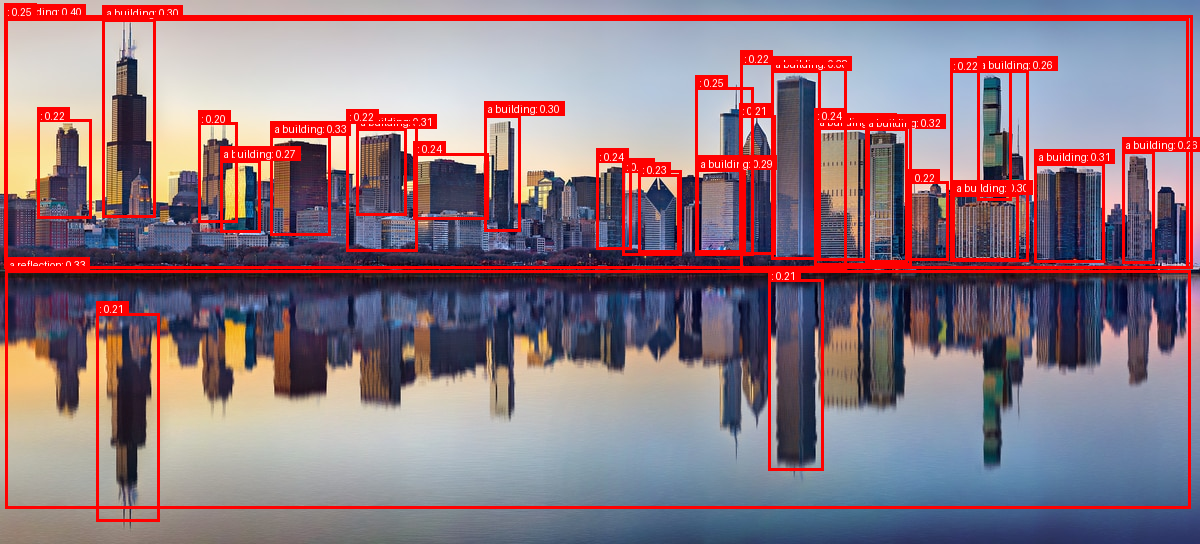

In [7]:
detection_client = DetectionClient(IMAGE_BASE_URL)

print(detection_client.health_check())
detection_results = detection_client.detect(TEST_IMAGE, ["a building", "a reflection of a building"], threshold=0.2)
draw_detections(TEST_IMAGE, detection_results)

### Image Segmentation

{'status': 'healthy', 'device': 'cuda', 'model': 'facebook/sam2.1-hiera-large'}


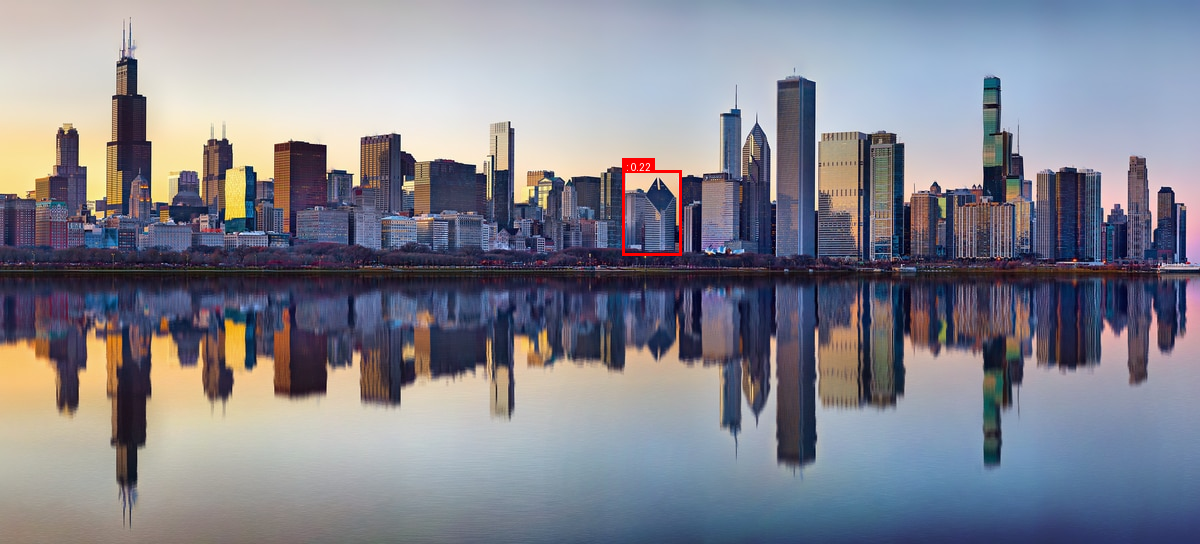

In [8]:
segmentation_client = SegmentationClient(IMAGE_BASE_URL)
print(segmentation_client.health_check())

target_idx = 13
tmp_result = deepcopy(detection_results)
tmp_result.detections[0].boxes = [tmp_result.detections[0].boxes[target_idx]]
tmp_result.detections[0].labels = [tmp_result.detections[0].labels[target_idx]]
tmp_result.detections[0].scores = [tmp_result.detections[0].scores[target_idx]]

bbox = tmp_result.detections[0].boxes[0]
center_point = [int((bbox[0]+bbox[2])//2), int((bbox[1]+bbox[3])//2)]

draw_detections(TEST_IMAGE, tmp_result)

#### Point

{'scores': [0.9139626622200012], 'shape': [1, 1, 544, 1200]}


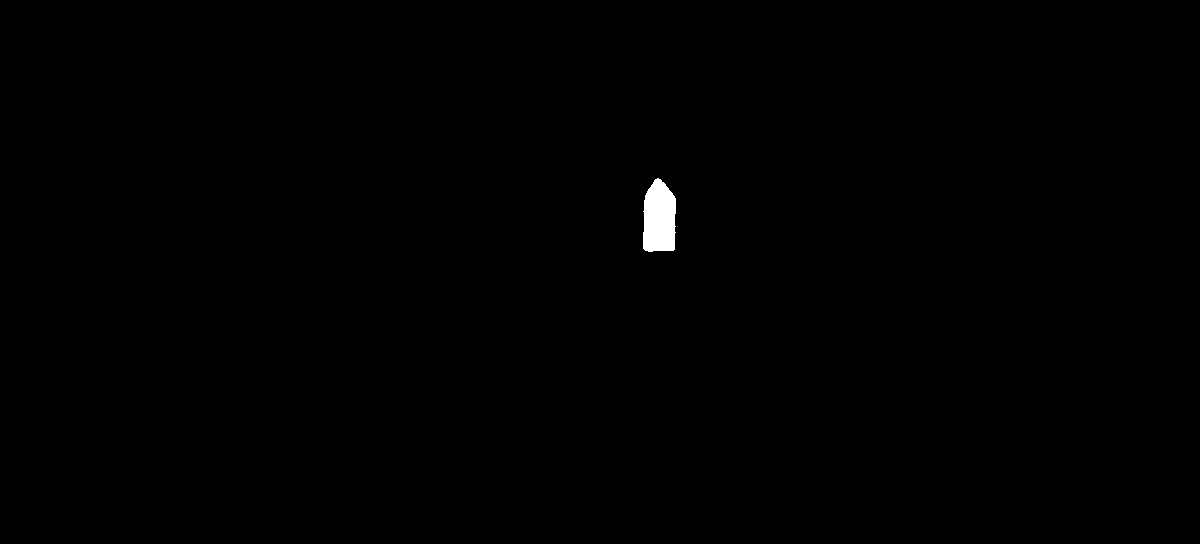

In [9]:
point_result = segmentation_client.segment_point(TEST_IMAGE, [center_point], [1])
print(point_result.get_metadata())
point_result.extract_masks()[0]

#### Box

{'scores': [0.9381392002105713], 'shape': [1, 1, 544, 1200]}


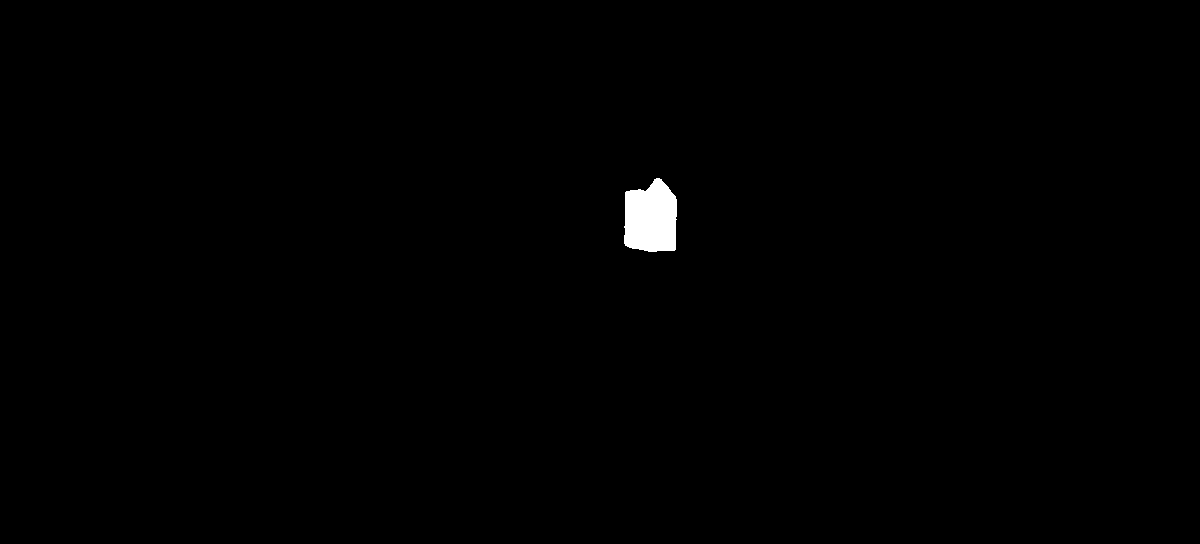

In [10]:
box_result = segmentation_client.segment_box(TEST_IMAGE, list(map(int, bbox)))
print(box_result.get_metadata())
box_result.extract_masks()[0]

#### Combined

{'scores': [0.8050936460494995], 'shape': [1, 1, 544, 1200]}


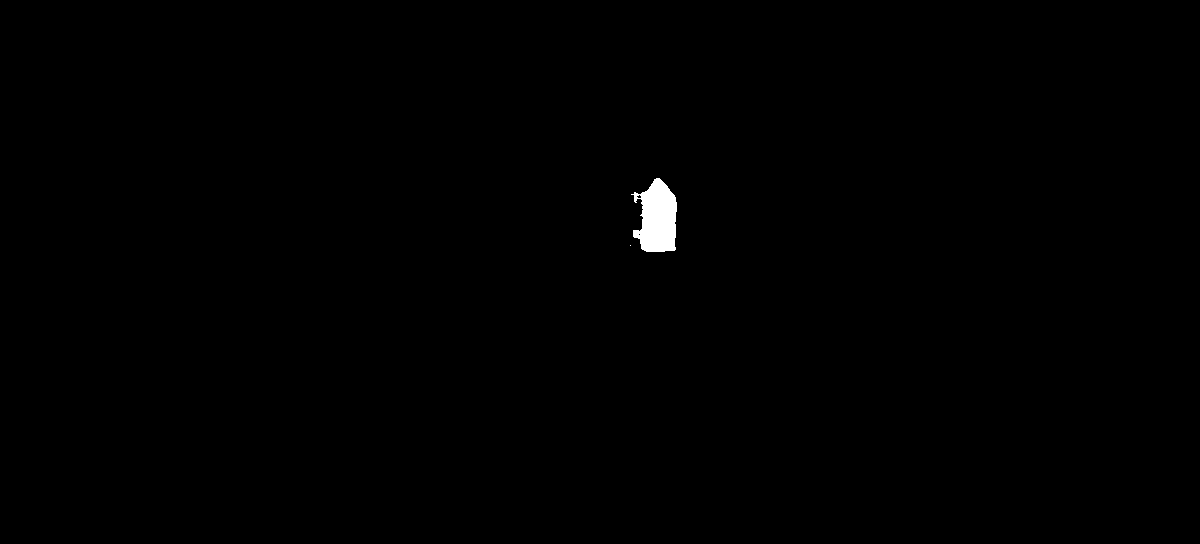

In [11]:
combined_result = segmentation_client.segment_combined(TEST_IMAGE, [[center_point[0] - 15, center_point[1]]], [0], list(map(int, bbox)))
print(combined_result.get_metadata())
combined_result.extract_masks()[0]